# Utiliser l'API de détection d'objet de TensorFlow

TensorFlow propose une librairie spécifique pour la détection d'objets, TF Object Detection, ou TFOD. 
Cette dernière propose une grande quantité de modèles préentraînés, ainsi que des scripts permettant de les re-entraîner facilement.

Dans ce notebook, nous allons détailler comment installer cette librairie, comment l'utiliser pour appliquer un modèle pré-entraîné à une image et pour visualiser les détections réalisées par ce modèle. 

Les étapes sont les suivantes :
- [Import des paquets nécessaires](#imports)
- [Installation de la librairie TFOD](#installation)
- [Choix et téléchargement d'un modèle](#modele)
- [Application du modèle à une image](#application)

# Imports
<a id='imports'></a>

Nous commençons par importer les paquets nécessaires pour ce notebook.

La commande ```%matplotlib inline``` permet d'afficher les graphiques de matplotlib avec la bibliothèque graphique intégrée à Notebook. Sans cette commande, les graphiques générés avec matplotlibne s'afficheront pas.

Les bibliothèques suivantes sont importées : 

- La bibliothèque ```OpenCV``` nous servira à lire les images avant qu'elles n'entrent dans le réseau de détection ;
- ```Matplotlib``` nous servira à afficher l'image avec les objets détectés ;
- ```Numpy``` sert à faire des calculs matriciels. Les images lues par ```OpenCV``` sont stockées comme des matrices ```Numpy``` ;
- ```os``` permet d'utiliser des fonctionnalités dépendantes du système d'exploitation, comme créer des dossiers, ou spécifier des chemins à partir de noms de dossiers ;
- ```Pathlib```  permet de manipuler des chemins ;
- ```TensorFlow``` permet de charger les modèles et de les appliquer.

In [1]:
%matplotlib inline

import numpy as np
import os
import pathlib
#from PIL import Image
import cv2
import tensorflow as tf

import matplotlib.pyplot as plt

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

# Installation de la librairie TFOD
<a id='installation'></a>

## Clonage du répertoire

La bibliothèque TF Object Detection se trouve dans le répertoire Model Garden, qui est un répertoire officiel de TensorFlow, hébergé sur Github. 

Nous allons cloner ce répertoire sur notre machine, dans le répertoire ```models```. 

Pour cela, on vérifie s'il a déjà été cloné, et sinon, on le clone. Selon la vitesse de votre connexion, cette étape peut être longue. 

In [2]:
if not os.path.exists(os.path.join('models', 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {models}

Une fois cette étape terminée, vous devriez disposer, dans le répertoire courant, d'un dossier intitulé ```models``` contenant plusieurs sous-dossiers. 

La librairie TFOD se situe dans le sous-dossier ```models/research/object_detection```. C'est le seul dossier du réperoire ```models``` que nous utiliserons. 

A cette étape, la librairie n'est pas encore installée. 

## Installation de Protobuf

Avant de pouvoir installer TF Object Detection, il est nécessaire d'installer sa dépendance, Protobuf.

Protobuf est une librairie développée par Google pour encoder, transmettre et décoder des informations rapidement entre deux programmes. Elle est utilisée par TFOD pour encoder la configuration des modèles, ainsi que leurs divers paramètres.

Afin de la télécharger et de l'installer, nous installons tout d'abord le paquet ```wget```, qui nous pemet de télécharger des paquets. 

In [3]:
!pip install wget
import wget

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Nous utilisons maintenant ```wget``` pour télécharger Protobuf. 

Pour cela, nous commençons par créer un dossier, ```protoc```, qui contiendra cette librairie. 

In [4]:
if not os.path.exists('protoc'):
    !mkdir 'protoc'

Le code présenté dans la cellule ci-dessous télécharge une version de la librairie adaptée à Windows. Si vous utilisez un autre système d'exploitation, vous devez modifier la version téléchargée. 

Après avoir téléchargé la librairie, nous la déplaçons vers le dossier ```protoc``` nouvellement créé et l'y décompressons.

In [5]:
url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
wget.download(url)
!move protoc-3.15.6-win64.zip {'protoc'}
!cd protoc && tar -xf protoc-3.15.6-win64.zip

100% [..........................................................................] 1468733 / 1468733

        1 fichier(s) d‚plac‚(s).


Nom de r‚pertoire non valide.


Enfin, nous ajoutons le chemin vers cette lib à la variable d'environnement PATH. 

In [6]:
os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join('protoc', 'bin'))  

## Installation de TFOD

Nous pouvons maintenant installer la librairie TFOD. 

Pour cela, allons tout d'abord nous placer dans le répertoire adéquat, ```models/research```, à l'aide de l'instruction ```!cd``` (le symbole ```!``` permet d'exécuter des commandes de l'invite de commandes dans une cellule du notebook). 

Ensuite,  nous utilisons le compilateur protoc pour générer des fichiers Python à partir des tous les fichiers de protocole .proto situés dans le dossier ```object_detection/protos```. Ces fichiers .proto contiennent les définitions des messages et des services utilisés par TFOD.

In [28]:
# Install TF Object detection API
!cd models/research && protoc object_detection/protos/*.proto --python_out=. 

Nous copions ensuite le fichier ```setup.py``` depuis le dossier ```object_detection/packages/tf2``` (qui contient des instructions d'installation pour TFOD) vers le dossier courant.

In [25]:
!cd models/research && copy object_detection\\packages\\tf2\\setup.py setup.py

        1 fichier(s) copi‚(s).


Nous pouvons ensuite installer la librairie.

In [29]:
!cd ../models/research && python -m pip install .

Il est possible que cette commande échoue, en renvoyant des messages d'erreur disant qu'il manque un paquet. 
Dans ce cas, installez ce paquet avec la commande ```!pip install <paquet_manquant>```, et relancez l'instruction d'installation.

Répétez cette opération tant que des paquets manquent.

## Vérification de l'installation

Une fois que l'installation a réussi, vous pouvez tester le bon fonctionnement de la bibliothèque grâce au script fourni par celle-ci. 
Pour cela, exécutez la commande suivante :

In [32]:
!python ../models/research/object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.9.13: C:\Program Files\Python39\python.exe
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2023-09-24 22:26:18.627247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 22:26:20.851446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1337 MB memory:  -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
C:\Users\ispri\AppData\Roaming\Python\Python39\site-packages\object_detection\builders\model_builder.py:1112: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(('Building experimental DeepMAC meta-arch.'
W0924 22:26:22.402759

I0924 22:26:42.709395  1668 efficientnet_model.py:143] round_filter input=1280 output=1408
I0924 22:26:42.740240  1668 efficientnet_model.py:453] Building model efficientnet with params ModelConfig(width_coefficient=1.1, depth_coefficient=1.2, resolution=260, dropout_rate=0.3, blocks=(BlockConfig(input_filters=32, output_filters=16, kernel_size=3, num_repeat=1, expand_ratio=1, strides=(1, 1), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=16, output_filters=24, kernel_size=3, num_repeat=2, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=24, output_filters=40, kernel_size=5, num_repeat=2, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=40, output_filters=80, kernel_size=3, num_repeat=3, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='dep

Une fois les tests terminés, vous verrez un message s'afficher. 

Si ce message indique que les tests ont été réalisés et que leur statut, indiqué sur la dernière ligne, est "OK" (certains tests peuvent potentiellement avoir été sautés), alors votre installation a réussi.

Dans le cas contraire, il se peut qu'il vous manque encore des paquets. 

Dans ce cas, installez les paquets manquants avec la commande pip install, relancez l'installation de TFOD, et relancez le script de vérification. 

# Choix du modèle et téléchargement du modèle
<a id='modele'></a>

## Choix du modèle
De nouveaux modèles de détection entaînés sur le jeu de données COCO 2017. 

Ils sont tous regroupés sur [cette page](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) : 

![TFODModelZoo](Utilisation_TFOD_pour_la_detection_TFODModelZoo.png)

Pour chaque modèle sont détaillés :
- son nom : ce nom contient le nom de l'architecture, mais aussi la taille de l'image utilisée en entrée (il n'est pas nécessaire de redimensionner vous-même les images d'entrée, cette étape est réalisée automatiquement par le réseau) ;
- sa vitesse de traitement en millisecondes par image ;
- sa précision sur COCO 2017, mesurée par la moyenne de la précision moyenne ;
- les types de sortie proposés. Les sorties peuvent être des boîtes englobantes (*bounding boxes*), des points d'intérêt (*keypoints*, utilisés pour l'estimation de pose par certains réseaux) ou des masques de segmentation. 

Dans cet exemple, nous allons utiliser le modèle *CenterNet Resnet50 V1 FPN 512x512*. C'est un modèle de type CenterNet, utilisant un réseau Resnet50 pour l'extraction des caractéristiques. Ce modèle est relativement rapide (27 ms par image), et il fournit en sortie des boîtes englobantes. 

Pour télécharger ce modèle, nous avons besoin de l'url d'où il peut être téléchargé. Cette url s'obtient en cliquant sur le modèle choisi sur [cette page](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). 

Notre modèle se trouve à l'adresse ```http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz```.

Nous avons également besoin du nom de l'archive, ```centernet_resnet50_v1_fpn_512x512_coco17_tpu-8```.

In [33]:
nom_modele = 'centernet_resnet50_v1_fpn_512x512_coco17_tpu-8'
url_modele = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz'

## Téléchargement du modèle

Nous allons tout d'abord créer un dossier dans ```models```, nommé ```trained_models```, qui contiendra tous les modèles pré-entraînés téléchargés. 

In [34]:
if not os.path.exists(os.path.join('models','trained-models')):
    !mkdir {os.path.join('models','trained-models')}

Nous téléchargeons maintenant le modèle avec le paquet ```wget```. 

Une fois le téléchargement terminé, nous le déplaçons dans le dossier ```trained_models``` nouvellement créé, et l'y décompressons. 

In [35]:
wget.download(url_modele)
!move {nom_modele +'.tar.gz'} {os.path.join('models','trained-models')}
!cd {os.path.join('models','trained-models')} && tar -zxvf {nom_modele +'.tar.gz'}

100% [......................................................................] 204067969 / 204067969        1 fichier(s) d‚plac‚(s).


x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/
x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/checkpoint/
x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/checkpoint/checkpoint
x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/checkpoint/ckpt-0.index
x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/pipeline.config
x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/saved_model/
x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/saved_model/saved_model.pb
x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/saved_model/variables/
x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/saved_model/variables/variables.index


Si vous regardez dans le dossier de votre modèle (```trained-models/centernet_resnet50_v1_fpn_512x512_coco17_tpu-8```), vous voyez deux sous-dossiers et un fichier :
- le sous-dossier ```checkpoint``` contient les fichiers où sont stockés les poids et les paramètres du modèle après chaque étape d'entraînement. Si vous souhaitez reprendre l'entraînement, par exemple pour réaliser un apprentissage par transfer, ce sont ces fichiers de checkpoint que vous utiliserez pour charger les poids et les paramètres actuels du modèle ;
- le sous-dossier ```saved_model``` contient la version exportée du modèle entraîné au format "SavedModel". Ce format est un format standard de TensorFlow pour l'exportation de modèles, qui permet de conserver tout le nécessaire utiliser le modèle entraîné ;
- Le fichier ```pipeline.config``` spécifie la configuration utilisée pour l'entraînement du modèle : architecture du modèle, paramètres d'entraînement, transformations de données, etc. C'est ce fichier de configuration qui guide le processus d'entraînement du modèle. Si vous souhaitez reprendre l'entraînement, ce fichier de configuration peut être mis à jour.

Dans cet exemple, nous allons simplement appliquer le modèle entraîné. Nous utiliserons donc uniquement le contenu du dossier ```saved_model```. 

# Application du modèle
<a id='application'></a>

## Appliquer le modèle à une image
Nous allons utiliser le modèle entraîné présent dans le dossier ```saved_model``` pour créer une fonction de détection, que nous appelons ```realiser_detection```. 

Cette fonction prend une image en entrée, et donne des détections en sortie. 

In [36]:
chemin_modele = os.path.join(os.path.join('models','trained-models'), nom_modele, "saved_model")
realiser_detection = tf.saved_model.load(chemin_modele)

On va appliquer la détection à une image représentant un chat et un chien. 

Commençons par charger et visualiser l'image. 

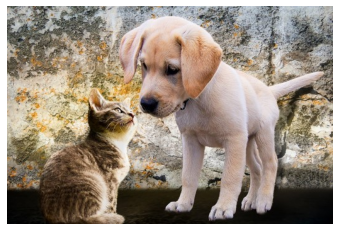

In [42]:
image_path = "Utilisation_TFOD_pour_la_detection_chat_et_chien.jpg"
image = cv2.imread(image_path)

# Afin de visualiser l'image avec Matplotlib, il est nécessaire de convertir l'ordre des canaux de couleur 
# depuis BGR (représentation utilisée par OpenCV) vers RGB (représentation utilisée par Matplotlib). 
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Masquer les axes
plt.show()

La fonction ```realiser_detection``` attend en entrée un lot de tenseurs TensorFlow. 

Nous commençons donc par convertir notre image en tenseur, à l'aide de la fonction ```tf.convert_to_tensor```. 

Nous ajoutons ensuite une dimension à ce tenseur, à l'aide de la fonction ```tf.newaxis```.

In [38]:
image_tenseur = tf.convert_to_tensor(image)
image_tenseur = image_tenseur[tf.newaxis, ...]

Nous pouvons maintenant appliquer notre fonction ```realiser_detection``` à notre image d'entrée. 

In [39]:
detections = realiser_detection(image_tenseur)

Affichons maintenant le résultat du modèle. 

In [18]:
print(detections)

{'detection_scores': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.87536955, 0.78076285, 0.4504379 , 0.08940352, 0.08684602,
        0.08657634, 0.07475711, 0.06381008, 0.05767919, 0.05048387,
        0.04754088, 0.04695352, 0.04491139, 0.04460245, 0.04370629,
        0.04366158, 0.04268035, 0.04053206, 0.04007638, 0.03967576,
        0.03843888, 0.03771508, 0.03627149, 0.03523336, 0.03457346,
        0.03456892, 0.03406956, 0.03370704, 0.03317648, 0.03253027,
        0.03200591, 0.03189166, 0.03186949, 0.03161706, 0.03114938,
        0.03100974, 0.03072738, 0.03069819, 0.03017912, 0.02960255,
        0.02910641, 0.02898227, 0.02890175, 0.02810343, 0.02802509,
        0.0279771 , 0.02781491, 0.02756624, 0.02726087, 0.02686362,
        0.02641768, 0.02544989, 0.02507681, 0.02502592, 0.02475004,
        0.02457134, 0.02429853, 0.02421982, 0.02395865, 0.02379441,
        0.0236292 , 0.02350496, 0.0232786 , 0.0232386 , 0.0231279 ,
        0.02298957, 0.02288065, 0.02284693, 0

La sortie de ce modèle est un dictionnaire contenant les éléments suivants: 
- le nombre de détections ;
- la classe la plus probable pour chaque détection. Chaque classe est représentée par un entier ;
- le score de détection de chaque détection, décrivant la probabilité que chaque détection contienne effectivement un objet ;
- les coordonnées des boîtes englobantes de chaque détection. 

Tous ces éléments sont encodés comme des tenseurs. 
Notons que chaque modèle de détection a des des sorties différentes. 
Tel quel, ce dictionnaire est difficilement interprétable à l'oeil nu. 

Heureusement, TFOD propose plusieurs outils pour aider à la visualisation de la sortie.

## Visualiser la sortie du modèle

Pour visualiser la sortie du modèle, nous avons besoin de deux choses :
- Convertir l'entier représentant la classe en une chaîne de caractères ;
- Afficher les boîtes englobantes des détections les plus probables, ainsi que la classe associée, sur l'image de départ. 

Nous commençons par la conversion des classes. 

### Convertir les classes depuis un entier vers une chaîne de caractères

Le fichier ```mscoco_label_map.pbtxt``` contient la liste des noms de classes utilisés pour l'ensemble de données COCO. Il se trouve à [cette adresse](https://github.com/tensorflow/models/tree/master/research/object_detection/data).

Il est au format ```.pbtxt``` (ProtoBuf Text), un format de texte utilisé pour définir des messages et des structures de données dans le système de sérialisation Protobuf.

Dans la cellule suivante, nous utilisons la librairie ```wget``` pour télécharger ce fichier dans notre dossier courant. 

In [19]:
etiquettes_url = "https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/"
etiquette_fichier = "mscoco_label_map.pbtxt"

wget.download(etiquettes_url + etiquette_fichier)

100% [................................................................................] 5056 / 5056

'mscoco_label_map.pbtxt'

Si vous ouvrez le fichier téléchargé, vous verrez qu'il met en correspondance, pour chaque classe, un identifiant numérique et son nom. 

![mscoco_label_map](Utilisation_TFOD_pour_la_detection_mscoco_label_map.png)

Nous allons maintenant utiliser la fonction ```create_category_index_from_labelmap``` du module ```label_map_util```, de la librairie TFOD. 

Cette fonction permet de créer un dictionnaire reliant les identifiants numériques des classes à leurs noms. 

In [20]:
from object_detection.utils import label_map_util

classes_dict = label_map_util.create_category_index_from_labelmap(etiquette_fichier,
                                                                    use_display_name=True)

In [21]:
print(classes_dict)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

### Afficher les boîtes englobantes des détections les plus probables

La fonction ```visualize_boxes_and_labels_on_image_array```du module ```visualization_utils``` permet d'afficher les détections comme des boîtes, et les classes associées comme du texte, sur l'image originale. 

Les arguments à donner en entrée sont les suivants :
- L'image où ajouter les détections (on choisit une copie de l'image donnée en entrée), au format d'une matrice Numpy ;
- Une matrice Numpy contenant les coordonnées des boîtes englobantes ;
- Une matrice Numpy contenant les identifiants numériques des boîtes englobantes ;      
- Une matrice Numpy contenant les scores des boîtes englobantes comme des nombes entiers ;
- Le dictionnaire reliant les identifiants numériques des classes à leur nom ;
- ```use_normalized_coordinates```, un booléen indiquant si les coordonnées des boîtes englobantes sont normalisées entre 0 et 1 ou non (pour ntore modèle, c'est le cas) ;
- ```max_boxes_to_draw```, le nombre maximal de boîtes à tracer (ce sont les boîtes avec le score le plus élevé qui sont tracées). Nous choisissons un nnombre maximal égal à 200 ;
- ```min_score_thresh```, un seuil sur le score minimal à obtenir pour qu'une boîte soit tracée. Nous choisissons un seuil égal à 0.3 ;
- ```agnostic_mode```, un booléen indiquant si le modèle est agnostique. Un modèle agnostique ne distingue pas les différentes classes d'objets lors de la détection. Dans ce cas, la fonction ne dessinera que les boîtes englobantes, sans afficher les classes de chaque objet détecté. Le modèle utilisé dans cet exemple n'est pas agnostique. 

Les éléments obtenus en sortie de la fonction de détection sont tous des tenseurs de lots. Avant de les passer en arguments à la fonction de visualisation, il est nécessaire de les convertir en matrices Numpy avec la méthode ```.numpy```, et de sélectionner uniquement le premier élément du lot. 

De plus, les indices des classes sont stockés comme des nombres réels, tandis que la fonction attend des entiers.

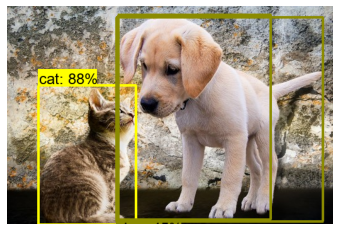

In [43]:
from object_detection.utils import visualization_utils

# Création de l'image sur laquelle les détections seront tracées
image_detection = image.copy()

# Conversion des sorties de la méthode de détection en matrices numpy
boites_detectees = detections['detection_boxes'][0].numpy()
classes_detectees = detections['detection_classes'][0].numpy()
scores_detectes = detections['detection_scores'][0].numpy()

# Conversion des indices des classes détectéés en entiers
classes_detectees = classes_detectees.astype(np.int64)

# Appel de la fonction de visualisation
visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_detection,
      boites_detectees,
      classes_detectees,
      scores_detectes,
      classes_dict,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_detection, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()